In [33]:

from sklearn.cluster import KMeans
from gensim.models import Word2Vec
import pandas as pd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import ast

In [62]:
df = pd.read_csv("swmax.csv")

# Word2Vec + Kmeans

In [63]:
sentences = df['tweet_tokens'].tolist()

w2v_model = Word2Vec(sentences, vector_size=300, window=10, min_count=1, workers=4)

def vectorize_tweet(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if len(vectors) == 0:
        return np.zeros(w2v_model.vector_size)
    else:
        return np.mean(vectors, axis=0)

df['tweet_tokens'] = df['tweet_tokens'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


model = w2v_model

def ReturnVector(x):
    if x in model.wv:
        return model.wv[x]
    else:
        return np.zeros(model.vector_size)

def Sentence_Vector(sentence):
    vectors = [ReturnVector(word) for word in sentence if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)



X = np.array([Sentence_Vector(tokens) for tokens in df['tweet_tokens']])


X_norm = normalize(X)

kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto', verbose=1)
labels = kmeans.fit_predict(X_norm)

print("Gotovi labeli:", labels)
print("Inercija:", kmeans.inertia_)


Initialization complete
Iteration 0, inertia 18347.345277701155.
Iteration 1, inertia 17320.806222362844.
Iteration 2, inertia 14452.429314796122.
Iteration 3, inertia 13312.93426267748.
Iteration 4, inertia 13277.75110886194.
Iteration 5, inertia 13277.545623214439.
Iteration 6, inertia 13276.962962731923.
Converged at iteration 6: center shift 1.40888948543075e-08 within tolerance 4.632967934170015e-08.
Gotovi labeli: [1 0 0 ... 0 0 0]
Inercija: 13276.962770601745


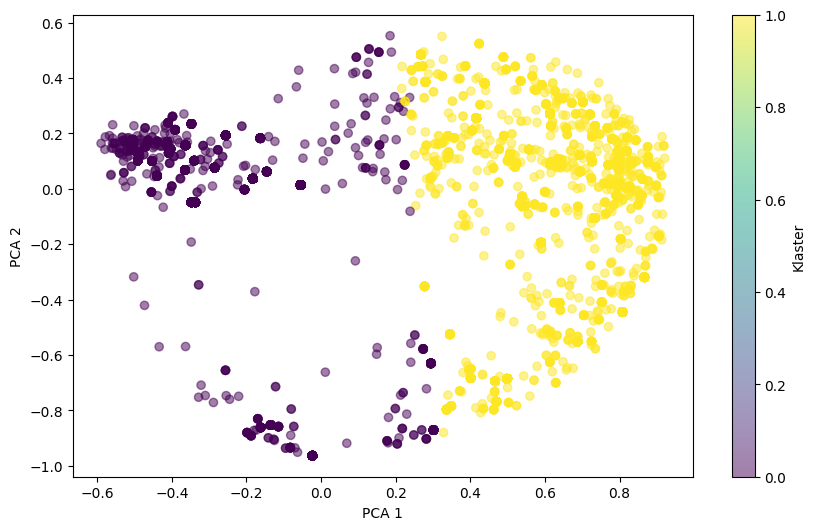

In [64]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Klaster")
plt.show()


In [67]:
from sklearn.metrics import adjusted_rand_score, accuracy_score


print("Adjusted Rand Index:", adjusted_rand_score(df['BinaryNumTarget'], labels))


Adjusted Rand Index: -2.8686362174065535e-05


In [66]:

from sklearn.metrics import confusion_matrix


def purity_score(y_true, y_pred):
  
    contingency_matrix = confusion_matrix(y_true, y_pred)
    
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

purity_score(df['BinaryNumTarget'].astype(int), labels)

0.5136405976377659

# Word2Vec + Aglomerativno hij

In [45]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import normalize

# === Prvo već imaš generisane Word2Vec vektore ===
# Pretpostavljamo: df['tweet_tokens'] je već evaluiran sa ast.literal_eval
# i da je X_norm već dobijen:

# Ako nemaš još y:
y = df['BinaryNumTarget'].values  # Prava klasa za evaluaciju

# === Uzorkovanje (2000 primera) za brže izvođenje ===
np.random.seed(42)
sample_indices = np.random.choice(len(X_norm), size=2000, replace=False)
X_sampled = X_norm[sample_indices]
y_sampled = y[sample_indices]

# === Aglomerativno klasterovanje ===
agglo = AgglomerativeClustering(n_clusters=2)
labels = agglo.fit_predict(X_sampled)

# === Evaluacija ===
ari = adjusted_rand_score(y_sampled, labels)
silhouette = silhouette_score(X_sampled, labels)

print("Gotovi labeli (Agglomerative):", labels)
print("Adjusted Rand Index (ARI):", ari)
print("Silhouette Score:", silhouette)


Gotovi labeli (Agglomerative): [1 1 1 ... 1 1 1]
Adjusted Rand Index (ARI): 0.00022984372230092496
Silhouette Score: 0.840481605349722


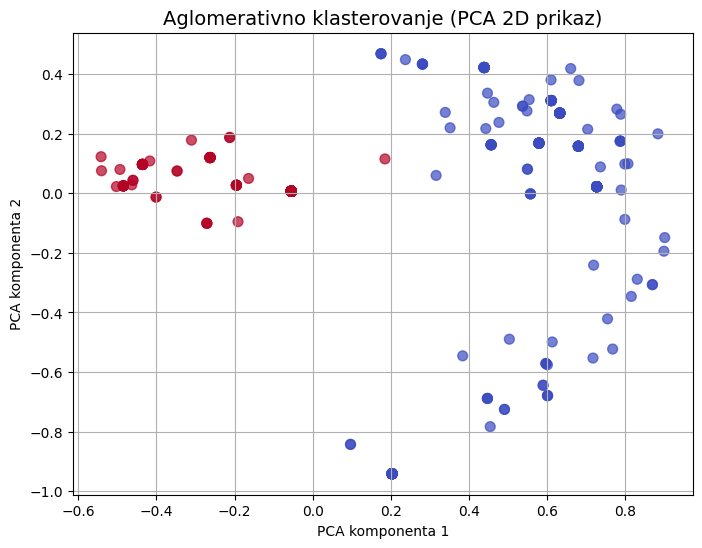

In [47]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === PCA redukcija na 2 dimenzije za vizualizaciju ===
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_sampled)

# === Crtanje klastera ===
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='coolwarm', s=50, alpha=0.7)
plt.title('Aglomerativno klasterovanje (PCA 2D prikaz)', fontsize=14)
plt.xlabel('PCA komponenta 1')
plt.ylabel('PCA komponenta 2')
plt.grid(True)
plt.show()


In [51]:
purity_score(y_sampled, labels)

0.511

# TF IDF + Kmeans

In [21]:
# TF IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000) 

X = vectorizer.fit_transform(df['tweet_new_x'])

X = X.toarray()

print("TF-IDF transformation complete. Shape:", X.shape)


num_clusters = 2


kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X)

print("Clustering complete. Cluster labels assigned!")

print("Adjusted Rand Index:", adjusted_rand_score(df['BinaryNumTarget'], df['cluster']))
print("Purity score:",purity_score(df['BinaryNumTarget'].astype(int), df['cluster']))


TF-IDF transformation complete. Shape: (134195, 5000)
Clustering complete. Cluster labels assigned!
Adjusted Rand Index: -0.0005590923957495106
Purity score: 0.5136405976377659


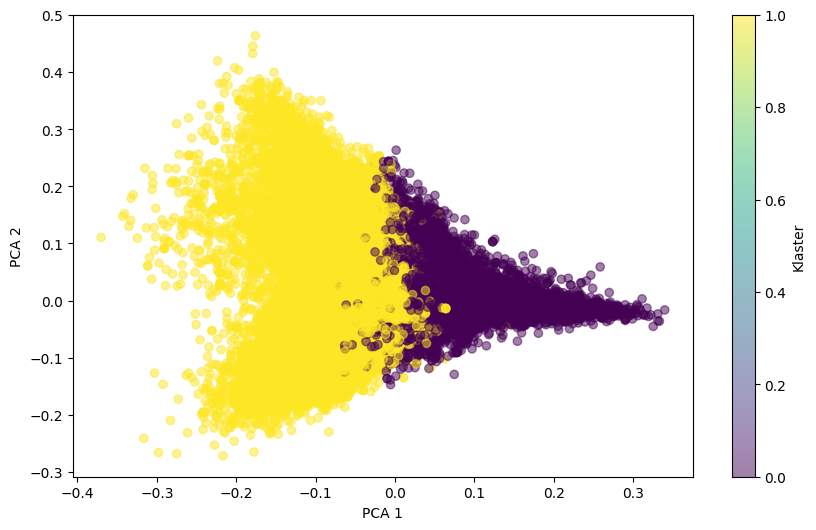

In [23]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Klaster")
plt.show()


# TF IDF + Aglomerativno hij

In [58]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import normalize

# Ako ti treba purity_score funkcija:
def purity_score(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    contingency_matrix = confusion_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

# TF-IDF transformacija
vectorizer = TfidfVectorizer(max_features=5000) 
X = vectorizer.fit_transform(df['tweet_new_x'])
X = X.toarray()

print("TF-IDF transformation complete. Shape:", X.shape)

# Normalizacija (opciono, možeš probati sa i bez)
X_norm = normalize(X)

# Aglomerativno klasterovanje
num_clusters = 2
agglo = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
labels = agglo.fit_predict(X_norm)

# Dodavanje labela u DataFrame
df['cluster'] = labels

# Evaluacija
print("Clustering complete. Cluster labels assigned!")
print("Adjusted Rand Index:", adjusted_rand_score(df['BinaryNumTarget'], df['cluster']))
print("Purity score:", purity_score(df['BinaryNumTarget'].astype(int), df['cluster']))


TF-IDF transformation complete. Shape: (134195, 5000)


MemoryError: Unable to allocate 67.1 GiB for an array with shape (9004081915,) and data type float64

# KMeans - features

In [25]:
# Grupa 1: Pozitivne emocije
positive_emotions = [
    'cheerfulness', 'joy', 'contentment', 'love', 'warmth',
    'positive_emotion', 'fun', 'giving', 'friends'
]

# Grupa 2: Negativne emocije
negative_emotions = [
    'sadness', 'disgust', 'suffering', 'negative_emotion',
    'weakness', 'neglect'
]

# Grupa 3: Socijalne emocije
social_emotions = [
    'pride', 'shame', 'politeness', 'affection', 'leader',
    'dominant_personality', 'childish', 'trust', 'sympathy'
]

# Grupa 4: Intenzivne emocije
intense_emotions = [
    'surprise', 'rage', 'horror', 'fear', 'exasperation',
    'nervousness', 'irritability', 'torment', 'pain', 'hate', 'anger'
]

# Grupa 5: Kognitivno-emotivne emocije
cognitive_emotions = [
    'anticipation', 'confusion', 'envy', 'disappointment',
    'optimism', 'zest', 'achievement'
]

# Kreiranje novih kolona kao zbir postojećih
df['emotion_positive'] = df[[f'empath_result.{x}' for x in positive_emotions]].sum(axis=1)
df['emotion_negative'] = df[[f'empath_result.{x}' for x in negative_emotions]].sum(axis=1)
df['emotion_social']   = df[[f'empath_result.{x}' for x in social_emotions]].sum(axis=1)
df['emotion_intense']  = df[[f'empath_result.{x}' for x in intense_emotions]].sum(axis=1)
df['emotion_cognitive'] = df[[f'empath_result.{x}' for x in cognitive_emotions]].sum(axis=1)


In [28]:
zalogskal = ['followers_count', 'favourites_count','friends_count',
       'statuses_count', 'listed_count', 'mentions', 'quotes']
for col in zalogskal:
    df[f'{col}'] = np.log1p(df[col])

In [31]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Pretpostavimo da koristiš već izvučene numeričke osobine
X_features = df[['Word count',
 'Max word length',
 'Min word length',
 'Average word length',
 'Present verbs',
 'Past verbs',
 'Adjectives',
 'Adverbs',
 'Pronouns',
 'Conjunctions',
 'Determiners',
 'Prepositions',
 'Digits',
 'followers_count',
 'favourites_count',
 'friends_count',
 'statuses_count',
 'listed_count',
 'cred',
 'BotScore',
 'normalize_influence',
 'emotion_positive',
 'emotion_negative',
 'emotion_social',
 'emotion_intense',
 'emotion_cognitive']]  # dodaš šta imaš

# Standardizacija
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X_features)

# KMeans klasterovanje
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_features)

# Evaluacija (ako imaš stvarne labele)
ari = adjusted_rand_score(df['BinaryNumTarget'], labels)


print("ARI:", ari)



ARI: 0.004033259107343632


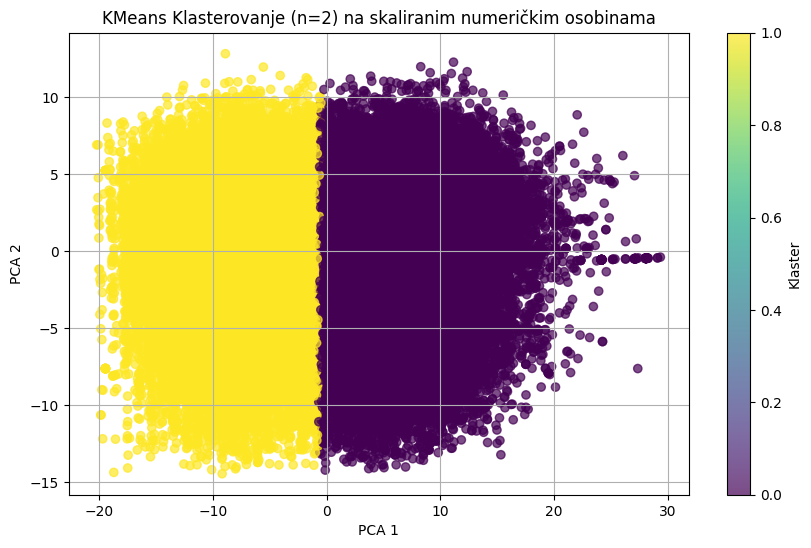

In [32]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_features)

# Crtanje
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title('KMeans Klasterovanje (n=2) na skaliranim numeričkim osobinama')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label='Klaster')
plt.grid(True)
plt.show()

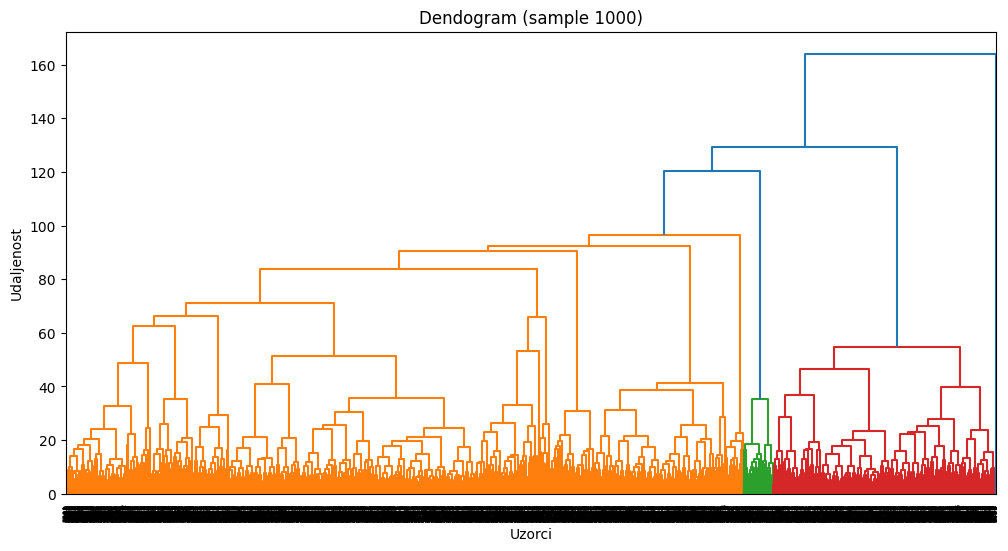

In [61]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Standardizacija
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

sample_indices = np.random.choice(X_scaled.shape[0], size=5000, replace=False)
X_sample = X_scaled[sample_indices]

# Dendogram na uzorku
linked = linkage(X_sample, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Dendogram (sample 1000)')
plt.xlabel('Uzorci')
plt.ylabel('Udaljenost')
plt.show()
